# RAMSES Nebular Line Emission

Braden Nowicki

Script to visualize RAMSES-RT Simulations of high-redshift galaxies in a variety of metal lines. Ionization Parameter, Number Density, and Temperature for each pixel are input into an interpolator for each line; the interpolator is created via the module 'emission.py'. 'emission.py' currently uses the 'linelist.dat' datatable to build interpolators; this can be adjusted to work with other tables from Cloudy runs. 

In [5]:
# importing packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import emission
import astropy

print(dir(emission))

import yt
from yt.units import dimensions
import copy

'''
cell_fields = [
    "Density",
    "x-velocity",
    "y-velocity",
    "z-velocity",
    "Pressure",
    "Metallicity",
    # "dark_matter_density",
    "xHI",
    "xHII",
    "xHeII",
    "xHeIII",
]
'''
epf = [
    ("particle_family", "b"),
    ("particle_tag", "b"),
    ("particle_birth_epoch", "d"),
    ("particle_metallicity", "d"),
]


# Cloudy Grid Run Bounds (log values)
# Umin, Umax, Ustep: -6.0 1.0 0.5
# Nmin, Nmax, Nstep: -1.0 6.0 0.5 
# Tmin, Tmax, Tstop: 3.0 6.0 0.1

lines=["H1_6562.80A","O1_1304.86A","O1_6300.30A","O2_3728.80A","O2_3726.10A","O3_1660.81A",
       "O3_1666.15A","O3_4363.21A","O3_4958.91A","O3_5006.84A", "He2_1640.41A","C2_1335.66A",
       "C3_1906.68A","C3_1908.73A","C4_1549.00A","Mg2_2795.53A","Mg2_2802.71A","Ne3_3868.76A",
       "Ne3_3967.47A","N5_1238.82A","N5_1242.80A","N4_1486.50A","N3_1749.67A","S2_6716.44A","S2_6730.82A"]

wavelengths=[6562.80, 1304.86, 6300.30, 3728.80, 3726.10, 1660.81, 1666.15, \
             4363.21, 4958.91, 5006.84, 1640.41, 1335.66, \
             1906.68, 1908.73, 1549.00, 2795.53, 2802.71, 3868.76, \
             3967.47, 1238.82, 1242.80, 1486.50, 1749.67, 6716.44, 6730.82]

'''
cell_fields = [
    "Density",
    "x-velocity",
    "y-velocity",
    "z-velocity",
    "Pressure",
    "Metallicity",
    # "dark_matter_density",
    "xHI",
    "xHII",
    "xHeII",
    "xHeIII",
]
'''
epf = [
    ("particle_family", "b"),
    ("particle_tag", "b"),
    ("particle_birth_epoch", "d"),
    ("particle_metallicity", "d"),
]

# Ionization Parameter Field
# Based on photon densities bins 2-4
# Don't include bin 1 -> Lyman Werner non-ionizing
def _ion_param(field, data): 
    from yt.frontends.ramses.field_handlers import RTFieldFileHandler
    p = RTFieldFileHandler.get_rt_parameters(ds).copy()
    p.update(ds.parameters)

    cgs_c = 2.99792458e10     #light velocity
    pd_2 = data['ramses-rt','Photon_density_2']*p["unit_pf"]/cgs_c #physical photon number density in cm-3
    pd_3 = data['ramses-rt','Photon_density_3']*p["unit_pf"]/cgs_c
    pd_4 = data['ramses-rt','Photon_density_4']*p["unit_pf"]/cgs_c

    photon = pd_2 + pd_3 + pd_4

    return photon/data['gas', 'number_density']  

# Temporarily testing rt fields
def _ion_param2(field, data): 
    from yt.frontends.ramses.field_handlers import RTFieldFileHandler
    p = RTFieldFileHandler.get_rt_parameters(ds).copy()
    p.update(ds.parameters)

    cgs_c =  2.99792458e10     #light velocity
    pd_2 = data['rt','photon_density_2']#*p["unit_pf"]/cgs_c #physical photon number density in cm-3
    pd_3 = data['rt','photon_density_3']#*p["unit_pf"]/cgs_c
    pd_4 = data['rt','photon_density_4']#*p["unit_pf"]/cgs_c

    photon = pd_2 + pd_3 + pd_4

    return photon/data['gas', 'number_density']*data['gas', 'number_density']/data['gas', 'number_density']

def get_luminosity(line):
   def _luminosity(field, data):
      return data['gas', 'intensity_' + line]*data['gas', 'volume']
   return copy.deepcopy(_luminosity)

yt.add_field(
    ('gas', 'ion-param'), 
    function=_ion_param, 
    sampling_type="cell", 
    units="cm**3", 
    force_override=True
)

yt.add_field(
    ('gas', 'ion-param2'), 
    function=_ion_param2, 
    sampling_type="cell", 
    units="1", 
    force_override=True
)

# True divides emissions by density squared in interpolator
dens_normalized = True
if dens_normalized: 
    units = '1/cm**6'
else:
    units = '1'

# Add intensity and luminosity fields for all lines in the list
for i in range(len(lines)):
    yt.add_field(
        #('gas', 'intensity_' + lines[i] + '_[erg_cm^{-2}_s^{-1}]'),
        ('gas', 'intensity_' + lines[i]),
        function=emission.get_line_emission(i, dens_normalized),
        sampling_type='cell',
        units=units,
        force_override=True
    )
    
    yt.add_field(
        ('gas', 'luminosity_' + lines[i]),
        function=get_luminosity(lines[i]),
        sampling_type='cell',
        units='1/cm**3',
        force_override=True
    )

yt.add_field(
        ('gas', 'intensity_halpha_norm'),
        function=emission.get_line_emission(0, True),
        sampling_type='cell',
        units='1/cm**6',
        force_override=True
)

yt.add_field(
        ('gas', 'intensity_oiii_norm'),
        function=emission.get_line_emission(9, True),
        sampling_type='cell',
        units='1/cm**6',
        force_override=True
)

f1 = "/Users/bnowicki/Documents/Research/Ricotti/output_00273"

ds = yt.load(f1, extra_particle_fields=epf)
ad = ds.all_data()

# For projections in a spherical region
sp = ds.sphere([0.49118094, 0.49275361, 0.49473726], (2000, "pc"))

ds.fields

yt : [INFO     ] 2024-12-22 15:58:23,488 Parameters: current_time              = 4.311420483661945
yt : [INFO     ] 2024-12-22 15:58:23,488 Parameters: domain_dimensions         = [64 64 64]
yt : [INFO     ] 2024-12-22 15:58:23,489 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-12-22 15:58:23,489 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-12-22 15:58:23,490 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-12-22 15:58:23,490 Parameters: current_redshift          = 12.171087046255657
yt : [INFO     ] 2024-12-22 15:58:23,490 Parameters: omega_lambda              = 0.685000002384186
yt : [INFO     ] 2024-12-22 15:58:23,491 Parameters: omega_matter              = 0.314999997615814
yt : [INFO     ] 2024-12-22 15:58:23,491 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-12-22 15:58:23,491 Parameters: hubble_constant           = 0.674000015258789
yt : [INFO     ] 2024-12-22 15:58:23,497 Detected RAMSES-RT 

['RegularGridInterpolator', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'copy', 'cub', 'd', 'dens_normalized_cub', 'dens_normalized_interpolator', 'dimN', 'dimT', 'dimU', 'filename', 'get_interpolator', 'get_line_emission', 'i', 'interpolator', 'lineidx', 'll', 'logN', 'logT', 'logU', 'maxN', 'maxT', 'maxU', 'minN', 'minT', 'minU', 'ncols', 'np', 'stepN', 'stepT', 'stepU', 'titls']


yt : [WARNING  ] 2024-12-22 15:58:28,206 This output has no cooling fields
yt : [WARNING  ] 2024-12-22 15:58:28,530 The DM particle filter already exists. Overriding.
yt : [WARNING  ] 2024-12-22 15:58:28,531 The star particle filter already exists. Overriding.
yt : [WARNING  ] 2024-12-22 15:58:28,531 The cloud particle filter already exists. Overriding.
yt : [WARNING  ] 2024-12-22 15:58:28,531 The dust particle filter already exists. Overriding.
yt : [WARNING  ] 2024-12-22 15:58:28,532 The star_tracer particle filter already exists. Overriding.
yt : [WARNING  ] 2024-12-22 15:58:28,532 The cloud_tracer particle filter already exists. Overriding.
yt : [WARNING  ] 2024-12-22 15:58:28,532 The dust_tracer particle filter already exists. Overriding.
yt : [WARNING  ] 2024-12-22 15:58:28,532 The gas_tracer particle filter already exists. Overriding.
yt : [INFO     ] 2024-12-22 15:58:28,533 Adding particle_type: DM
yt : [INFO     ] 2024-12-22 15:58:28,541 Adding particle_type: star
yt : [INFO  

In [ ]:
pos=np.transpose(np.array(ad['nbody', 'particle_position']))
x_pos = pos[0]
y_pos = pos[1]
z_pos = pos[2]
x_center = np.mean(x_pos)
y_center = np.mean(y_pos)
z_center = np.mean(z_pos)
x_pos = x_pos - x_center
y_pos = y_pos - y_center
z_pos = z_pos - z_center
ctr_at_code = np.array([x_center, y_center, z_center])
print(ctr_at_code)
sp = ds.sphere(ctr_at_code, (700, "pc"))


[[0.00830391 0.07622376 0.0066368  ... 0.43256877 0.4330908  0.4331388 ]
 [0.05788639 0.06096357 0.00279235 ... 0.49887328 0.4944558  0.49828279]
 [0.00912372 0.00579271 0.067574   ... 0.55736528 0.5579638  0.56084366]]
[0.49150722 0.49334852 0.49472129]


In [6]:
x_pos = np.array(ad["star", "particle_position_x"])
y_pos = np.array(ad["star", "particle_position_y"])
z_pos = np.array(ad["star", "particle_position_z"])
x_center = np.mean(x_pos)
y_center = np.mean(y_pos)
z_center = np.mean(z_pos)
x_pos = x_pos - x_center
y_pos = y_pos - y_center
z_pos = z_pos - z_center
ctr_at_code = np.array([x_center, y_center, z_center])
print(ctr_at_code)

[0.49117112 0.49277624 0.49474927]


In [22]:
ctr_den=ad.quantities.max_location(("gas", "number_density"))
val, x_pos, y_pos, z_pos = ctr_den
ctr = [x_pos.value, y_pos.value, z_pos.value]
print(ctr)

[array(0.49117091), array(0.49277613), array(0.49475035)]


In [12]:
print(np.array(ad['nbody', 'particle_position']))

[[0.00830391 0.05788639 0.00912372]
 [0.07622376 0.06096357 0.00579271]
 [0.0066368  0.00279235 0.067574  ]
 ...
 [0.43256877 0.49887328 0.55736528]
 [0.4330908  0.4944558  0.5579638 ]
 [0.4331388  0.49828279 0.56084366]]


In [13]:
print(ds.current_redshift)

12.171087046255657


## Visualizing Simulation Parameters Ionization Parameter, Density, Temperature

In [ ]:
# TODO
# gas metallicity in solar or not? divide by 0.02?

In [3]:
print(ad['gas', 'volume'])

[6.54221705e+69 6.54221705e+69 6.54221705e+69 ... 6.54221705e+69
 6.54221705e+69 6.54221705e+69] cm**3


In [8]:
print(max(ad['gas', 'intensity_H1_6562.80A']))

3.950176739399894e-14 cm**(-6)


In [19]:
ion_param_min = min(ad['gas', 'ion-param'])
ion_param_max = max(ad['gas', 'ion-param'])
number_density_min = min(ad['gas', 'number_density'])
number_density_max = max(ad['gas', 'number_density'])
temp_min = min(ad['gas', 'temperature'])
temp_max = max(ad['gas', 'temperature'])

print(ion_param_min, ion_param_max, number_density_min, number_density_max, \
      temp_min, temp_max)

1.1573547165671049e-46 cm**3 6.13359414584941 cm**3 1.72502697376353e-08 cm**(-3) 139742.19487627852 cm**(-3) 0.0 K 2451449966.2156982 K


In [ ]:
# U -46 1
# N -8 5
# T 0.0K 9

In [17]:
# For projections in a spherical region
sp = ds.sphere([0.49118094, 0.49275361, 0.49473726], (700, "pc"))

yt : [INFO     ] 2024-12-18 14:08:23,190 Projection completed
yt : [INFO     ] 2024-12-18 14:08:23,190 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-12-18 14:08:23,191 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-12-18 14:08:23,192 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-12-18 14:08:23,192 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-12-18 14:08:23,193 Making a fixed resolution buffer of (('gas', 'ion-param')) 1000 by 1000



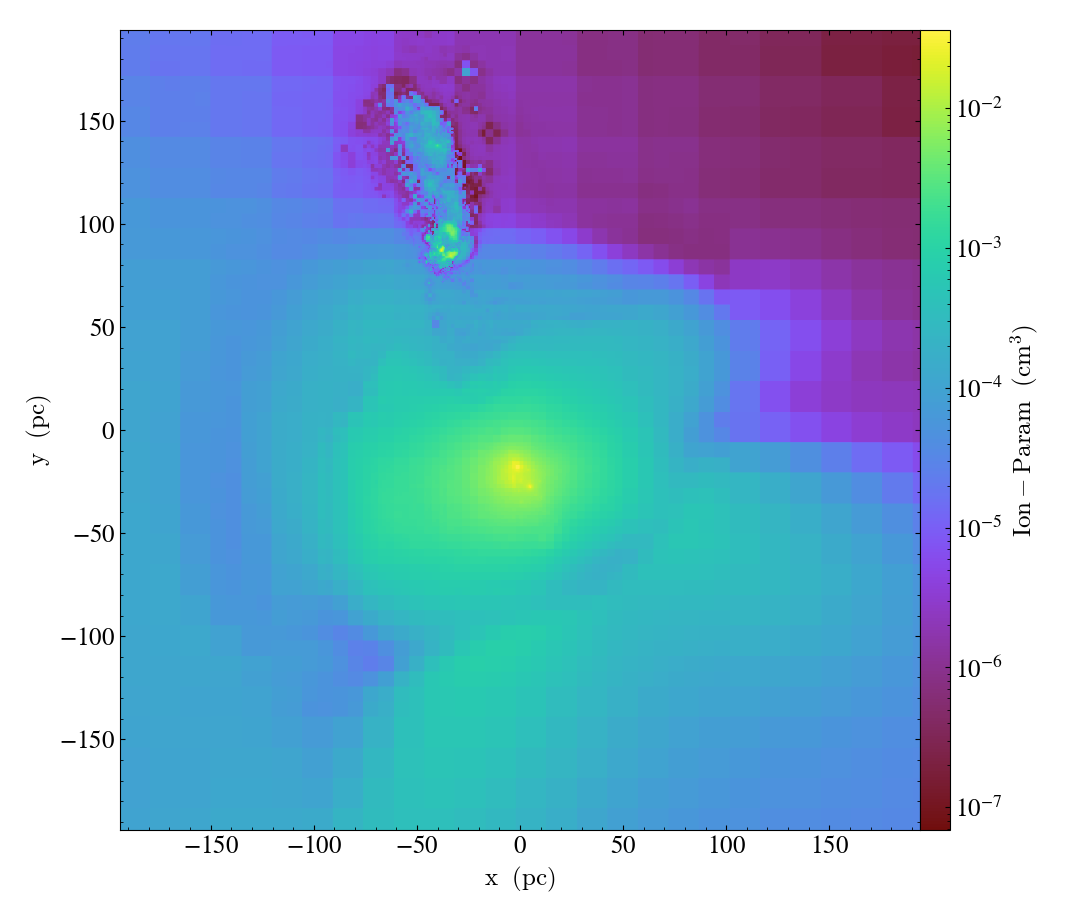

In [18]:
# Ionization Parameter
p = yt.ProjectionPlot(ds, "z", ("gas", "ion-param"), width=0.0001,
                      weight_field=("gas", "number_density"),
                      data_source=sp,
                      buff_size=(1000, 1000),
                      center=[0.49118094, 0.49275361, 0.49473726])
                      #center=ctr_at_code)

#p.save()
p.show()

yt : [INFO     ] 2024-10-27 12:56:25,312 Projection completed
yt : [INFO     ] 2024-10-27 12:56:25,313 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 12:56:25,313 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 12:56:25,315 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 12:56:25,315 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 12:56:25,316 Making a fixed resolution buffer of (('gas', 'ion-param2')) 1000 by 1000



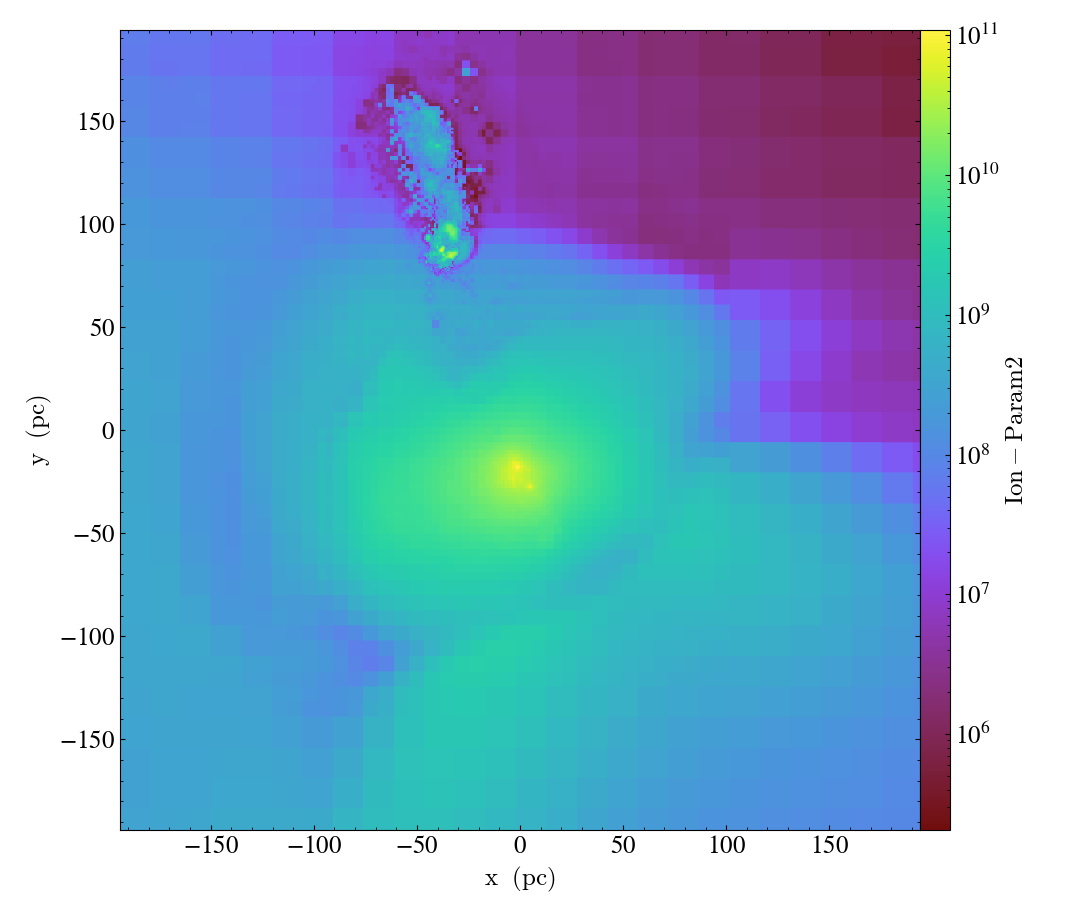

In [29]:
# Ionization Parameter
p = yt.ProjectionPlot(ds, "z", ("gas", "ion-param2"), width=0.0001,
                      weight_field=("gas", "number_density"),
                      data_source=sp,
                      buff_size=(1000, 1000),
                      center=[0.49118094, 0.49275361, 0.49473726])

#p.save()
p.show()

In [30]:
r = ad['gas', 'ion-param']/ad['gas', 'ion-param2']

In [11]:
print(min(r), max(r))

3.335640951981503e-13 cm**3 3.335640951981507e-13 cm**3


yt : [INFO     ] 2024-10-27 12:58:33,830 Projection completed
yt : [INFO     ] 2024-10-27 12:58:33,831 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 12:58:33,831 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 12:58:33,832 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 12:58:33,832 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 12:58:33,833 Making a fixed resolution buffer of (('gas', 'number_density')) 1000 by 1000



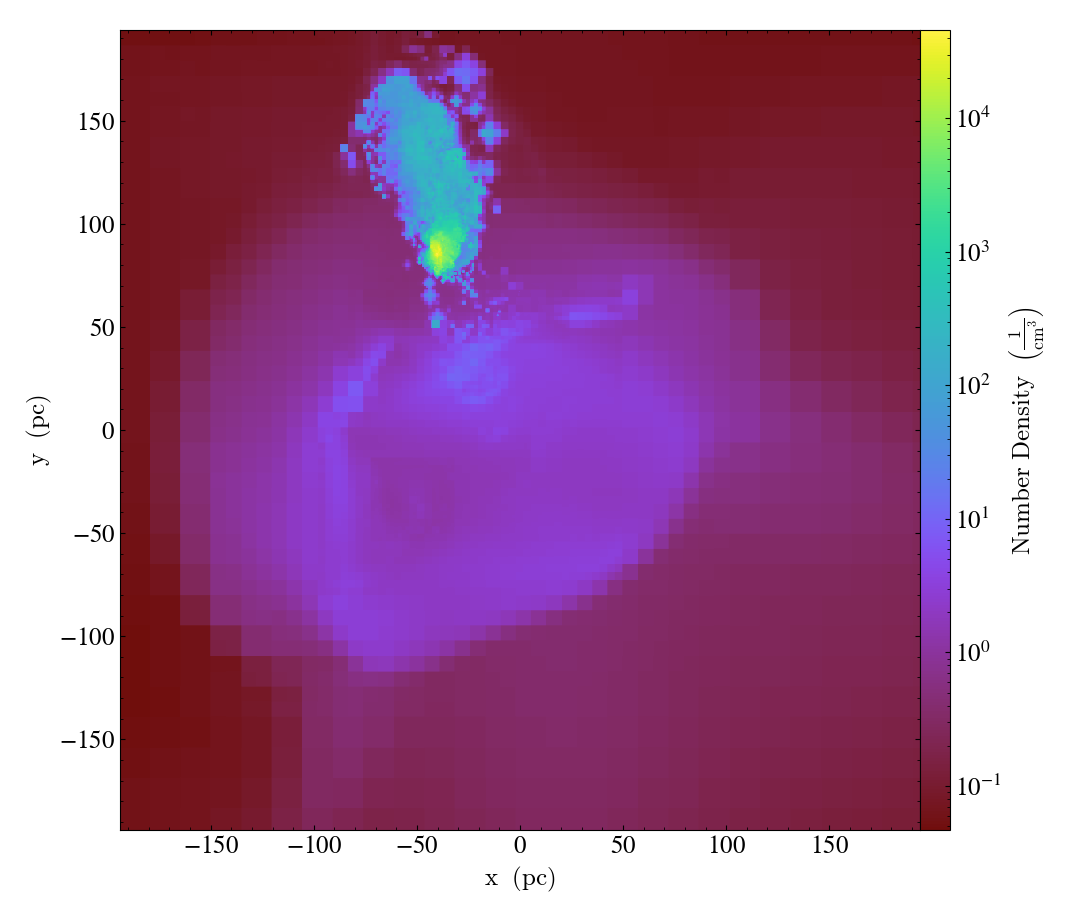

In [31]:
# Number Density
p = yt.ProjectionPlot(ds, "z", ("gas", "number_density"), width=0.0001,
                      weight_field=("gas", "number_density"),
                      data_source=sp,
                      buff_size=(1000, 1000),
                      center=[0.49118094, 0.49275361, 0.49473726])

#p.save()
p.show()

yt : [INFO     ] 2024-10-27 12:58:38,174 Projection completed
yt : [INFO     ] 2024-10-27 12:58:38,175 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 12:58:38,175 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 12:58:38,177 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 12:58:38,177 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 12:58:38,178 Making a fixed resolution buffer of (('gas', 'density')) 1000 by 1000



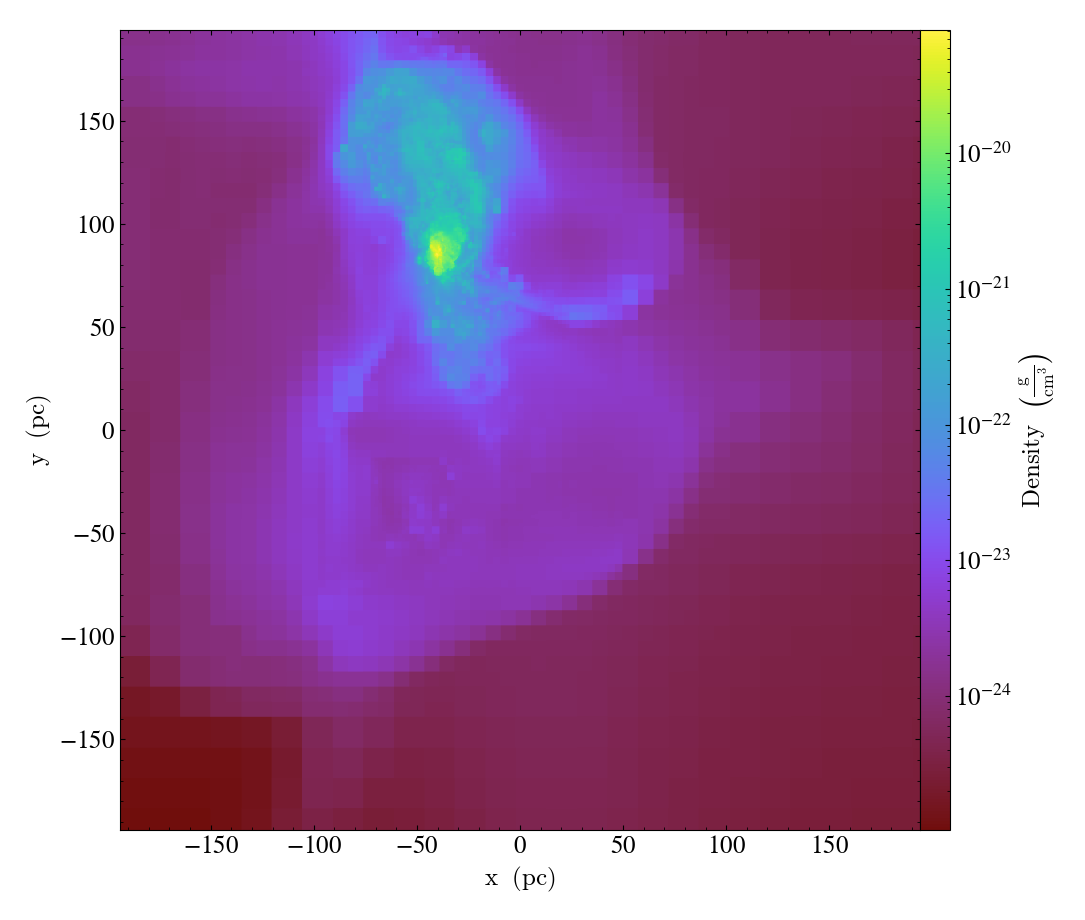

In [32]:
# Mass Density
p = yt.ProjectionPlot(ds, "z", ("gas", "density"), width=0.0001,
                      weight_field=("gas", "number_density"),
                      data_source=sp,
                      buff_size=(1000, 1000),
                      center=[0.49118094, 0.49275361, 0.49473726])

#p.save()
p.show()

yt : [INFO     ] 2024-10-27 12:58:42,586 Projection completed
yt : [INFO     ] 2024-10-27 12:58:42,587 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 12:58:42,587 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 12:58:42,588 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 12:58:42,589 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 12:58:42,589 Making a fixed resolution buffer of (('gas', 'temperature')) 1000 by 1000



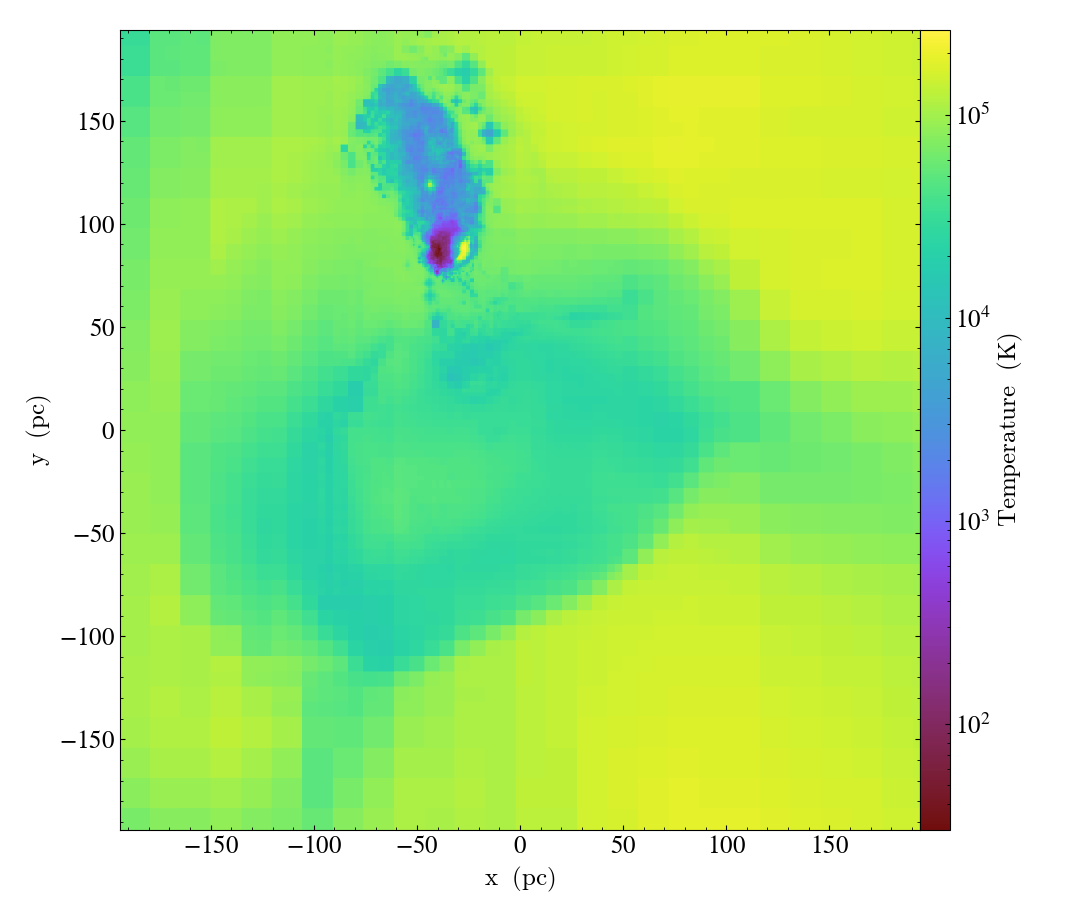

In [33]:
# Temperature
p = yt.ProjectionPlot(ds, "z", ("gas", "temperature"), width=0.0001,
                      weight_field=("gas", "number_density"),
                      data_source=sp,
                      buff_size=(1000, 1000),
                      center=[0.49118094, 0.49275361, 0.49473726])

#p.save()
p.show()

In [34]:
# Metallicity
p = yt.ProjectionPlot(ds, "z", ("gas", "metallicity"), width=0.0001,
                      weight_field=("gas", "number_density"),
                      data_source=sp,
                      buff_size=(1000, 1000),
                      center=[0.49118094, 0.49275361, 0.49473726])

#p.save()
p.show()

yt : [INFO     ] 2024-10-27 12:58:47,671 Projection completed
yt : [INFO     ] 2024-10-27 12:58:47,671 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 12:58:47,671 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 12:58:47,672 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-27 12:58:47,673 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-27 12:58:47,673 Making a fixed resolution buffer of (('gas', 'metallicity')) 1000 by 1000


## Visualizing Line Intensities

yt : [INFO     ] 2024-10-31 16:23:28,740 Projection completed
yt : [INFO     ] 2024-10-31 16:23:28,744 xlim = 0.490923 0.491439
yt : [INFO     ] 2024-10-31 16:23:28,744 ylim = 0.492496 0.493011
yt : [INFO     ] 2024-10-31 16:23:28,747 xlim = 0.490923 0.491439
yt : [INFO     ] 2024-10-31 16:23:28,747 ylim = 0.492496 0.493011
yt : [INFO     ] 2024-10-31 16:23:28,750 Making a fixed resolution buffer of (('gas', 'intensity_H1_6562.80A')) 1000 by 1000



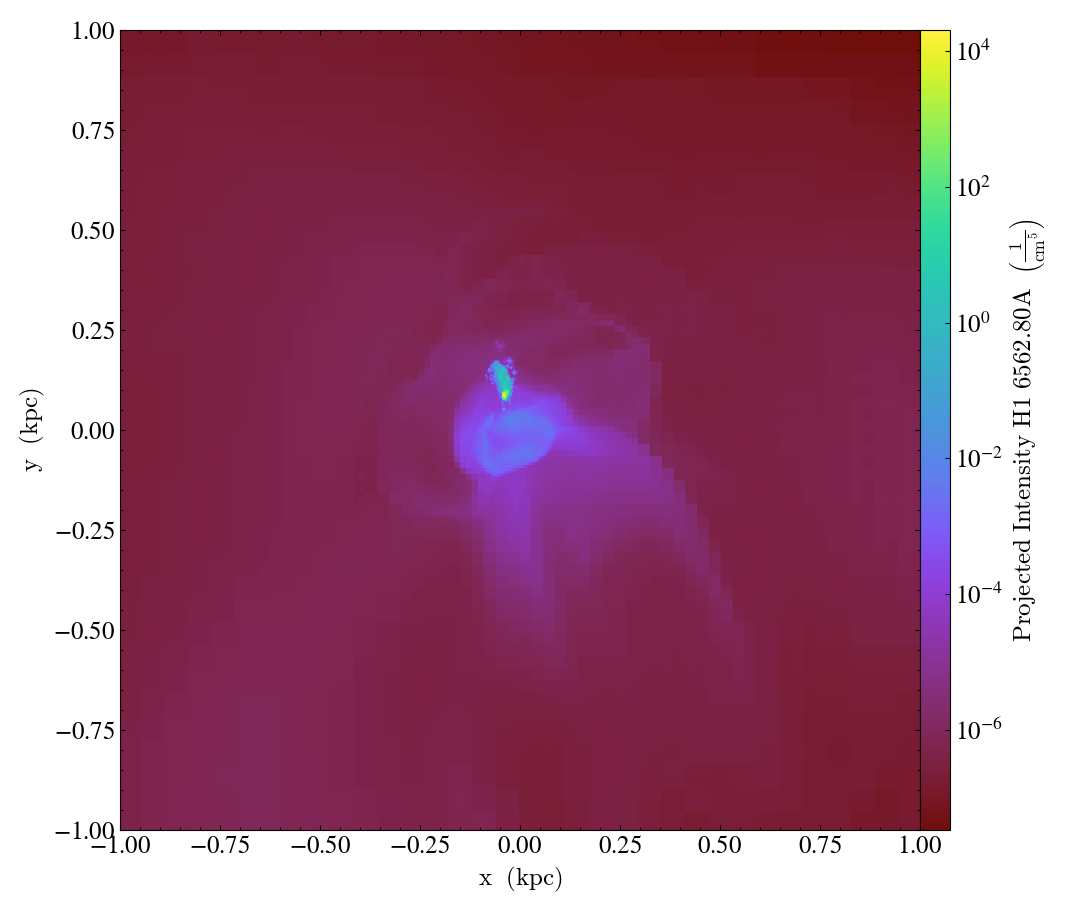

In [ ]:
p = yt.ProjectionPlot(ds, "z", ("gas", "intensity_H1_6562.80A"), width=(2, 'kpc'),
                      #weight_field=("gas", "number_density"),
                      buff_size=(1000, 1000),
                      data_source=sp,
                      center=[0.49118094, 0.49275361, 0.49473726])

#p.save()
p.show()

# 2kpc/1000 pixels
# mult by 4pc^2 in cm area Check TODO 10e42
# sum gaussians at each point with equiv width, angstrom 
# delta lam/lam = v/c = 1/3000

# baseline noise level 10e-22, flux*normalized gaussians


In [4]:
p = yt.ProjectionPlot(ds, "z", ("gas", "luminosity_H1_6562.80A"), width=(500, 'pc'),
                      #weight_field=("gas", "number_density"),
                      buff_size=(1000, 1000),
                      data_source=sp,
                      center=[0.49118094, 0.49275361, 0.49473726])

#p.save()
p.show()

yt : [INFO     ] 2024-11-06 14:37:02,918 Projection completed
yt : [INFO     ] 2024-11-06 14:37:02,921 xlim = 0.491116 0.491245
yt : [INFO     ] 2024-11-06 14:37:02,921 ylim = 0.492689 0.492818
yt : [INFO     ] 2024-11-06 14:37:02,922 xlim = 0.491116 0.491245
yt : [INFO     ] 2024-11-06 14:37:02,922 ylim = 0.492689 0.492818
yt : [INFO     ] 2024-11-06 14:37:02,925 Making a fixed resolution buffer of (('gas', 'luminosity_H1_6562.80A')) 1000 by 1000


In [14]:
halpha_total_luminosity = sum(ad['gas', 'luminosity_H1_6562.80A'])
halpha_total_intensity = sum(ad['gas', 'intensity_H1_6562.80A'])

/Users/bnowicki/Documents/GitHub/NebularLines/emission.py:96: RuntimeWarning: divide by zero encountered in log10
  T = np.log10(T_val)


In [15]:
print(halpha_total_luminosity)
print(halpha_total_intensity)
print(halpha_total_intensity*(4*3.086e18)**2)

5.5406318133887476e+42 cm**(-3)
1.8345744278360062e-11 cm**(-6)
2.7954206028409136e+27 cm**(-6)


In [7]:
#print(halpha_total_luminosity.value)
print(max(ad['gas', 'luminosity_H1_6562.80A']))

1.4345698869905137e+40 cm**(-3)


In [ ]:
# TODO Plot spectrum - sum total intensities of galaxy in different lines
# straight line, units
# for different snapshots - intensity evolution in time
# colorbar on interpgrid
# larger cloudy table 
# erg/s - sum over total area, sum all pixels multiply  by pixel areas
# divide by width of line ; (erg/s/line unit without)
# JWST spectrograph resolution
# delta lambda/lambda = 1/R = delta v/c
# delta v 100km/s at best 
# 10km/s

# redshift by 1+z longer
# divide by delta lambda = lambda/R
# square of width delta lambda center at lambda, area prod of intensity times delta lambda erg/s
# observe flux
# zaratan supercomputer
# L/4pi d^2 flux


# distance from z - astropy
# flux instead of luminosity
# line width JWST 500 km/s, per Angstrom
# 

yt : [INFO     ] 2024-10-31 15:52:03,021 Projection completed
yt : [INFO     ] 2024-10-31 15:52:03,022 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-31 15:52:03,022 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-31 15:52:03,024 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-31 15:52:03,024 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-31 15:52:03,025 Making a fixed resolution buffer of (('gas', 'intensity_halpha_norm')) 1000 by 1000



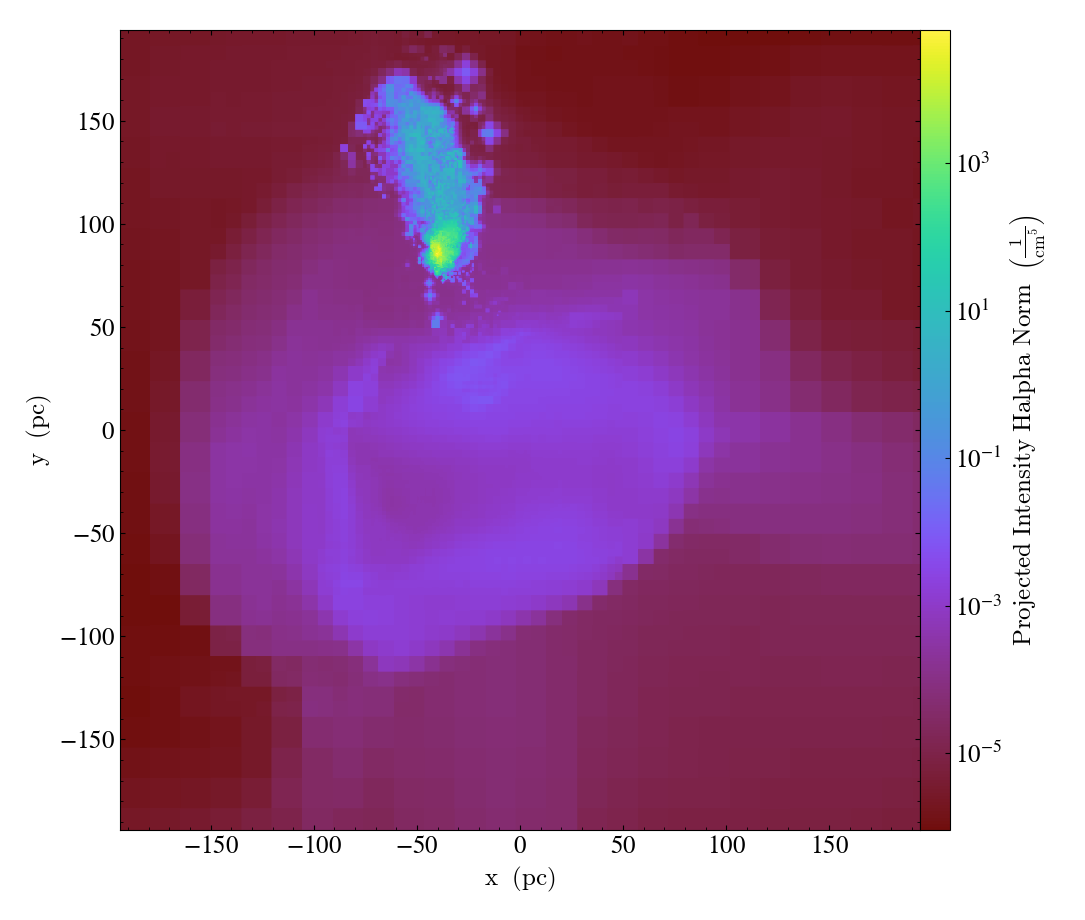

In [4]:
p = yt.ProjectionPlot(ds, "z", ("gas", "intensity_halpha_norm"), width=0.0001,
                      buff_size=(1000, 1000),
                      data_source=sp,
                      center=[0.49118094, 0.49275361, 0.49473726])

#p.save()
p.show()

In [8]:
def _H1_ratio_test(field, data):
    return data["intensity_H1_6562.80A"]/data["intensity_halpha_norm"]

ds.add_field(
    ('gas', 'H1_ratio'),
    function=_H1_ratio_test,
    sampling_type='cell',
    units='1',
    force_override=True
)

def _OIII_ratio_test(field, data):
    return data["intensity_O3_5006.84A"]/data["intensity_oiii_norm"]

ds.add_field(
    ('gas', 'OIII_ratio'),
    function=_OIII_ratio_test,
    sampling_type='cell',
    units='1',
    force_override=True
)

In [9]:
p = yt.ProjectionPlot(ds, "z", ("gas", "H1_ratio"), width=0.0001,
                      weight_field=("gas", "number_density"),
                      buff_size=(1000, 1000),
                      data_source=sp,
                      center=[0.49118094, 0.49275361, 0.49473726])

p.show()

yt : [INFO     ] 2024-10-31 16:09:36,472 Projection completed
yt : [INFO     ] 2024-10-31 16:09:36,473 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-31 16:09:36,473 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-31 16:09:36,475 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-31 16:09:36,475 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-31 16:09:36,476 Making a fixed resolution buffer of (('gas', 'H1_ratio')) 1000 by 1000


yt : [INFO     ] 2024-10-31 16:10:43,448 Projection completed
yt : [INFO     ] 2024-10-31 16:10:43,448 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-31 16:10:43,448 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-31 16:10:43,450 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-31 16:10:43,450 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-31 16:10:43,451 Making a fixed resolution buffer of (('gas', 'intensity_oiii_norm')) 1000 by 1000



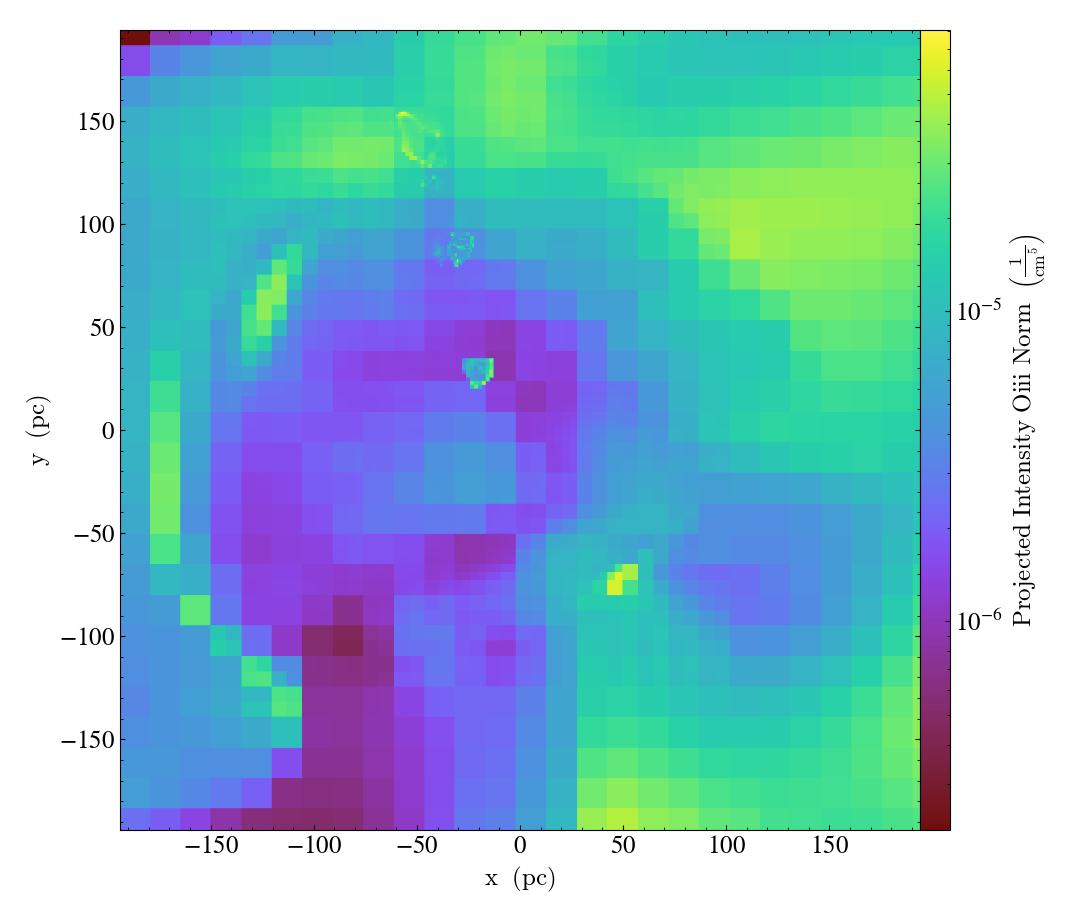

In [13]:
p = yt.ProjectionPlot(ds, "z", ("gas", "intensity_oiii_norm"), width=0.0001,
                      buff_size=(1000, 1000),
                      data_source=sp,
                      center=[0.49118094, 0.49275361, 0.49473726])

#p.save()
p.show()

yt : [INFO     ] 2024-10-31 16:04:53,259 Projection completed
yt : [INFO     ] 2024-10-31 16:04:53,260 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-31 16:04:53,260 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-31 16:04:53,261 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-31 16:04:53,261 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-31 16:04:53,262 Making a fixed resolution buffer of (('gas', 'intensity_O3_5006.84A')) 1000 by 1000



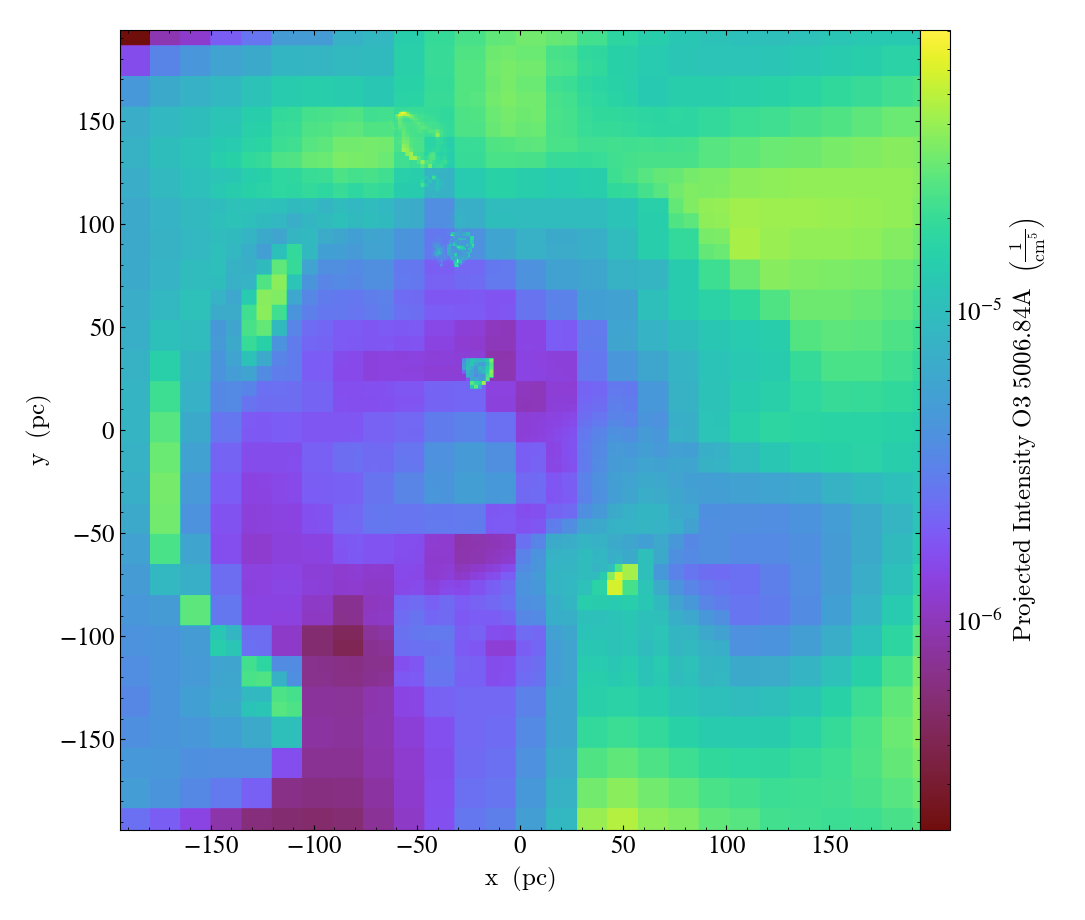

In [4]:
p = yt.ProjectionPlot(ds, "z", ("gas", "intensity_O3_5006.84A"), width=0.0001,
                      #weight_field=("gas", "number_density"),
                      buff_size=(1000, 1000),
                      data_source=sp,
                      center=[0.49118094, 0.49275361, 0.49473726])

#p.save()
p.show()

yt : [INFO     ] 2024-10-31 14:14:12,994 Projection completed
yt : [INFO     ] 2024-10-31 14:14:12,995 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-31 14:14:12,996 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-31 14:14:12,997 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-31 14:14:12,997 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-31 14:14:12,998 Making a fixed resolution buffer of (('gas', 'OIII_ratio')) 1000 by 1000



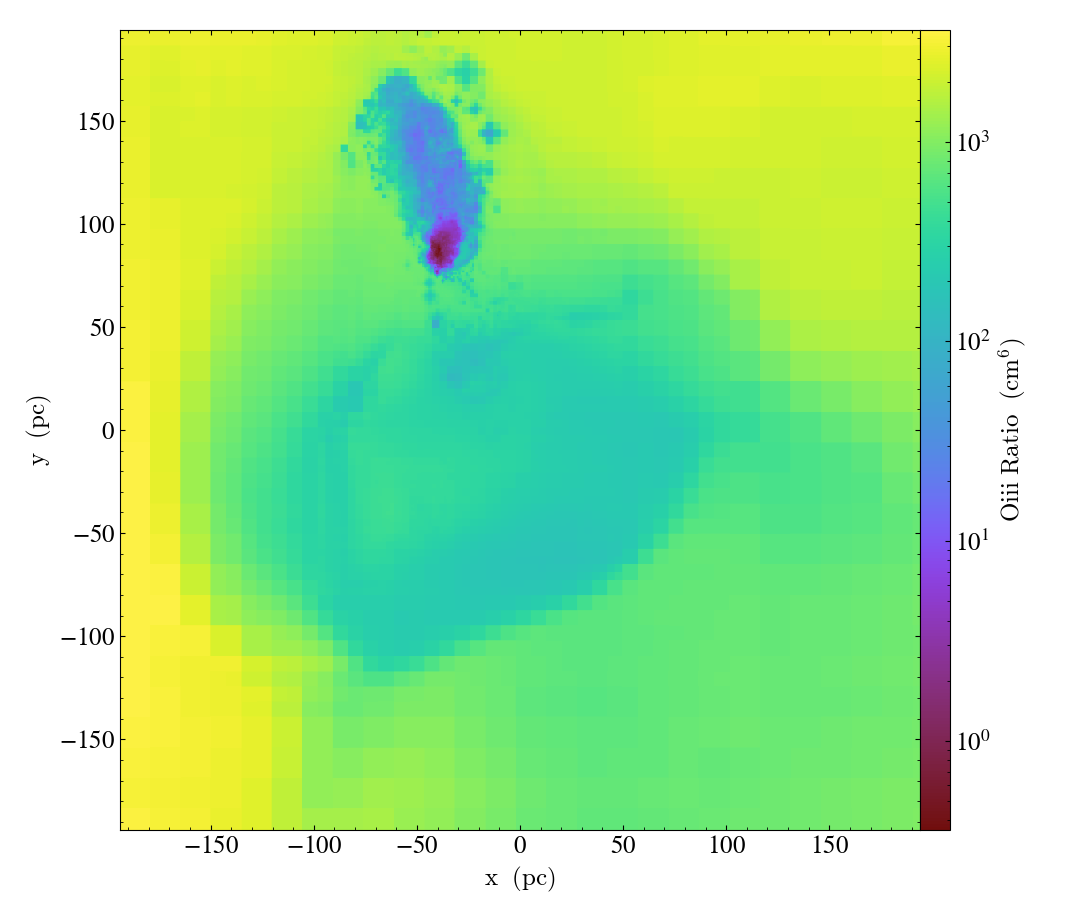

In [47]:
p = yt.ProjectionPlot(ds, "z", ("gas", "OIII_ratio"), width=0.0001,
                      weight_field=("gas", "number_density"),
                      buff_size=(1000, 1000),
                      data_source=sp,
                      center=[0.49118094, 0.49275361, 0.49473726])

p.show()

In [14]:
p = yt.ProjectionPlot(ds, "z", ("gas", "intensity_He2_1640.41A"), width=0.0001,
                      #weight_field=("gas", "number_density"),
                      buff_size=(1000, 1000),
                      data_source=sp,
                      center=[0.49118094, 0.49275361, 0.49473726])

#p.save()
p.show()

yt : [INFO     ] 2024-10-28 18:07:48,446 Projection completed
yt : [INFO     ] 2024-10-28 18:07:48,447 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-28 18:07:48,448 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-28 18:07:48,449 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-28 18:07:48,450 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-28 18:07:48,450 Making a fixed resolution buffer of (('gas', 'intensity_He2_1640.41A')) 1000 by 1000


yt : [INFO     ] 2024-10-31 16:16:50,540 Projection completed
yt : [INFO     ] 2024-10-31 16:16:50,543 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-31 16:16:50,543 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-31 16:16:50,545 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-31 16:16:50,545 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-31 16:16:50,547 Making a fixed resolution buffer of (('gas', 'intensity_O1_6300.30A')) 1000 by 1000



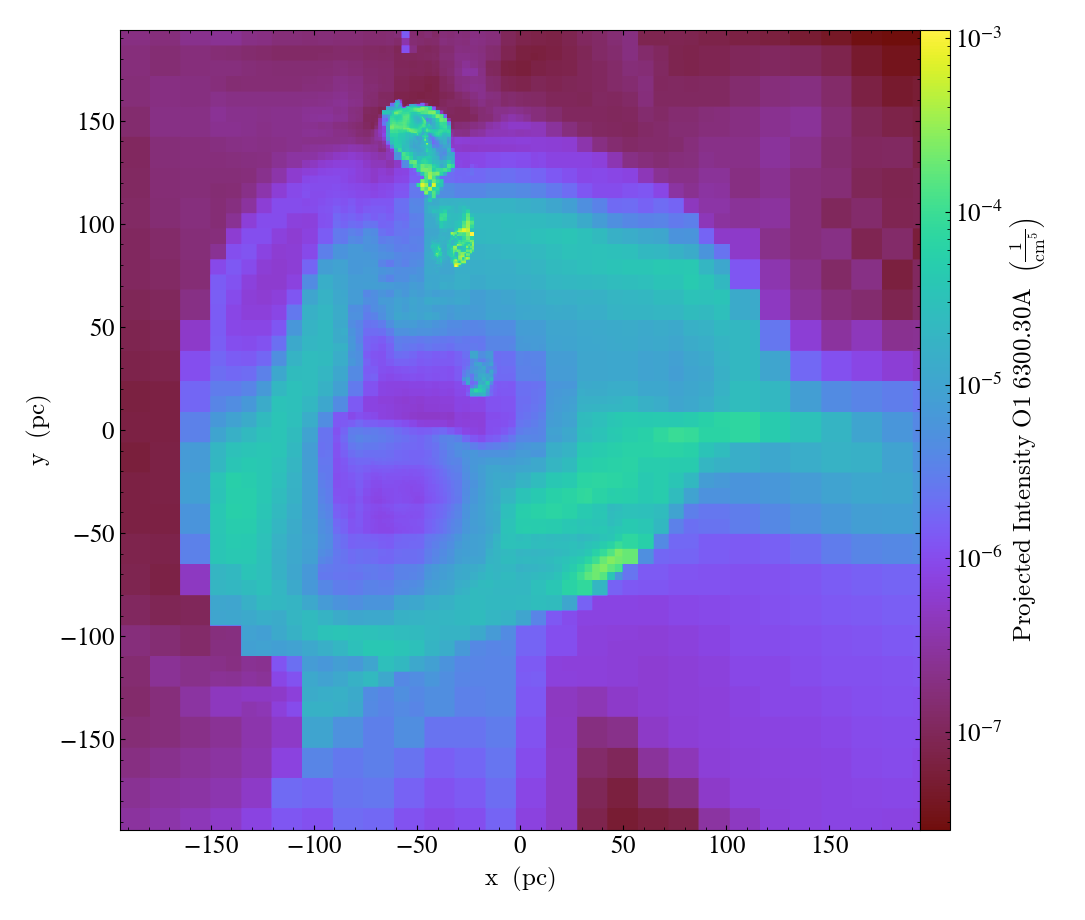

In [3]:
p = yt.ProjectionPlot(ds, "z", ("gas", "intensity_O1_6300.30A"), width=0.0001,
                      #weight_field=("gas", "number_density"),
                      buff_size=(1000, 1000),
                      data_source=sp,
                      center=[0.49118094, 0.49275361, 0.49473726])

#p.save()
p.show()

## Luminosity-Wavelength Spectrum

In [10]:
luminosities=[]

for line in lines:
    luminosity=ad['gas', 'luminosity_' + line].sum()
    luminosities.append(luminosity.value)


/Users/bnowicki/Documents/GitHub/NebularLines/emission.py:96: RuntimeWarning: divide by zero encountered in log10
  T = np.log10(T_val)


In [25]:
from astropy.cosmology import FlatLambdaCDM
from scipy.special import voigt_profile

z = ds.current_redshift
omega_matter = ds.omega_matter
omega_lambda = ds.omega_lambda
cosmo = FlatLambdaCDM(H0=70, Om0=omega_matter)#, Om0=0.3)
d_l = cosmo.luminosity_distance(z)*3.086e24 # convert Mpc to cm
flux_arr = luminosities/(4*np.pi*d_l**2)#/100

# resolving power
# R = lambda/delta_lambda
R = 1000

print(flux_arr.value)
flux_arr = flux_arr.value

[2.85288199e-18 5.22471939e-22 4.57302849e-24 2.65243781e-22
 1.80428918e-22 2.19527848e-23 6.42888396e-23 1.24056437e-23
 3.90186559e-23 1.16415899e-22 8.17034270e-24 4.86695735e-22
 2.04466925e-22 1.29581237e-22 2.02003717e-26 1.89674805e-21
 9.47122817e-22 1.09339755e-23 3.31865207e-24 3.41030746e-23
 1.70130756e-23 2.22721892e-23 1.31030414e-23 2.97165655e-23
 2.09566648e-23]


In [30]:

def plot_spectra(wavelengths, luminosities, flux_arr, z, noise_lvl, R, \
                 sim_spectra=False, redshift_wavelengths=False):

    fig, (ax1, ax2) = plt.subplots(2, sharex=True)

    # Display spectra at redshifted wavelengths
    # lambda_obs = (1+z)*lambda_rest
    if redshift_wavelengths:
        wavelengths = (1+z)*wavelengths

    line_widths = np.array(wavelengths)/R # Angstrom

    if sim_spectra:
        x_range, y_vals_l = plot_voigts(wavelengths, luminosities, line_widths, [0.0]*len(wavelengths), noise_lvl)
        x_range, y_vals_f = plot_voigts(wavelengths, flux_arr, line_widths, [0.0]*len(wavelengths), noise_lvl)
        ax1.plot(x_range, np.log10(y_vals_f))
        ax2.plot(x_range, np.log10(y_vals_l))
        ax2.set_xlabel(r'Wavelength [$\AA$]')
        ax1.set_ylabel(r'Log(Flux) [$erg s^{-1} cm^{-2}$]')
        ax2.set_ylabel(r'Log(Luminosity) [$erg s^{-1}$]')
    else:
        ax1.plot(wavelengths, np.log10(flux_arr), 'o')
        ax2.plot(wavelengths, np.log10(luminosities), 'o')
        ax2.set_xlabel(r'Wavelength [$\AA$]')
        ax1.set_ylabel(r'Log(Flux) [$erg s^{-1} cm^{-2}$]')
        ax2.set_ylabel(r'Log(Luminosity) [$erg s^{-1}$]')

# Plot voigt profiles for spectral lines over a noise level
# sigma - stdev of normal dist
# gamma - FWHM of cauchy dist
def plot_voigts(centers, amplitudes, sigmas, gammas, noise_lvl):

    x_range = np.linspace(min(centers) - 20, max(centers) + 20, 1000)
    y_vals = np.zeros_like(x_range)+noise_lvl

    for amp, center, sigma, gamma in zip(amplitudes, centers, sigmas, gammas):
        if amp > noise_lvl:
            y_vals += (amp-noise_lvl)*voigt_profile(x_range - center, sigma, gamma)

    return x_range, y_vals

# TODO mult metallicity by 4?

plot_spectra(wavelengths, luminosities, flux_arr, z, 10e-25, R, sim_spectra=False, \
             redshift_wavelengths=False)

plot_spectra(wavelengths, luminosities, flux_arr, z, 10e-25, R, sim_spectra=True, \
             redshift_wavelengths=False)

plt.show()

In [23]:
from astropy.cosmology import FlatLambdaCDM
print(luminosities)

z = 6.145
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
d_l = cosmo.luminosity_distance(z)*3.086e24
flux_arr = luminosities/(4*np.pi*d_l**2)#/100
print(flux_arr)

# mult metallicity by 4
print(flux_arr.value)

[array(5.54063181e+42), array(1.01470185e+39), array(8.88135831e+36), array(5.15134568e+38), array(3.50414145e+38), array(4.26348857e+37), array(1.24856475e+38), array(2.40932167e+37), array(7.57788113e+37), array(2.26093345e+38), array(1.58677649e+37), array(9.45220267e+38), array(3.97098777e+38), array(2.51661978e+38), array(3.92314938e+34), array(3.68370743e+39), array(1.83942372e+39), array(2.12350643e+37), array(6.445212e+36), array(6.62321754e+37), array(3.30413905e+37), array(4.32552066e+37), array(2.54476449e+37), array(5.77130596e+37), array(4.07003038e+37)]
[1.31420798e-17 2.40681806e-21 2.10661028e-23 1.22187140e-21
 8.31163447e-22 1.01127649e-22 2.96152824e-22 5.71478103e-23
 1.79743252e-22 5.36281216e-22 3.76374823e-23 2.24201148e-21
 9.41896876e-22 5.96928636e-22 9.30549867e-26 8.73755529e-21
 4.36301384e-21 5.03684270e-23 1.52876952e-23 1.57099147e-22
 7.83723958e-23 1.02599016e-22 6.03604408e-23 1.36892264e-22
 9.65389248e-23] 1 / Mpc2
[1.31420798e-17 2.40681806e-21 2.1

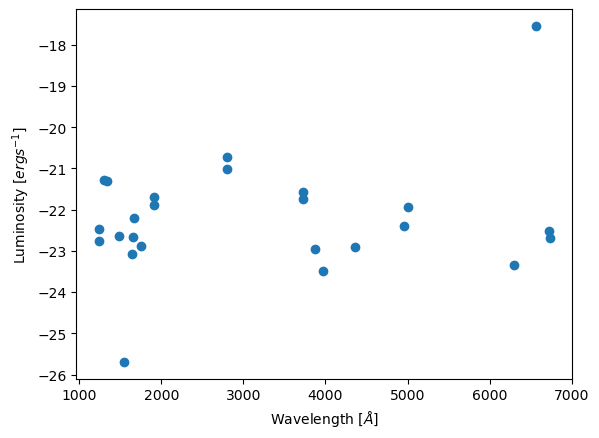

In [21]:
def plot_spectrum(wavelengths, luminosities):
    fig = plt.figure()
    plt.plot(wavelengths, np.log10(flux_arr.value), 'o')  # Plot the points as markers
    #plt.vlines(wavelengths, 0, np.log(luminosities), linestyles='-')  # Draw vertical lines from x-axis to the points
    plt.xlabel(r'Wavelength [$\AA$]')
    plt.ylabel(r'Luminosity [$erg s^{-1}$]')
# metal lines by factor of 4
plot_spectrum(wavelengths, luminosities)
# obs noise 10e-21
plt.show()

In [ ]:
from scipy.special import voigt_profile

def plot_voigts(x_points, amplitudes, centers, sigmas, gammas):
    x_range = np.linspace(min(x_points) - 5, max(x_points) + 5, 1000)
    y_values = np.zeros_like(x_range)

    for amp, center, sigma, gamma in zip(amplitudes, centers, sigmas, gammas):
        y_values += amp * voigt_profile(x_range - center, sigma, gamma)

    plt.plot(x_range, y_values)
    plt.scatter(x_points, [0] * len(x_points), color='red')  # Mark the points
    plt.xlabel('x')
    plt.ylabel('Intensity')
    plt.title('Voigt Profiles at Points')
    plt.show()

# Example usage
x_points = [1, 3, 5]
amplitudes = [1, 0.5, 1.2]
centers = [1, 3, 5]
sigmas = [0.5, 0.8, 0.6]
gammas = [0.2, 0.3, 0.4]

plot_voigts(x_points, amplitudes, centers, sigmas, gammas)

## OII Ratio

### Calculate OII Ratio at each Pixel then Project

In [15]:
p = yt.ProjectionPlot(ds, "z", ("gas", "intensity_O2_3728.80A"), width=0.0001,
                      #weight_field=("gas", "number_density"),
                      buff_size=(1000, 1000),
                      data_source=sp,
                      center=[0.49118094, 0.49275361, 0.49473726])

#p.save()
p.show()

yt : [INFO     ] 2024-10-28 18:07:55,044 Projection completed
yt : [INFO     ] 2024-10-28 18:07:55,045 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-28 18:07:55,045 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-28 18:07:55,046 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-28 18:07:55,047 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-28 18:07:55,048 Making a fixed resolution buffer of (('gas', 'intensity_O2_3728.80A')) 1000 by 1000


In [19]:
p = yt.ProjectionPlot(ds, "z", ("gas", "intensity_O2_3726.10A"), width=0.0001,
                      #weight_field=("gas", "number_density"),
                      buff_size=(1000, 1000),
                      data_source=sp,
                      center=[0.49118094, 0.49275361, 0.49473726])

#p.save()
p.show()

yt : [INFO     ] 2024-10-28 18:09:23,335 Projection completed
yt : [INFO     ] 2024-10-28 18:09:23,336 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-28 18:09:23,336 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-28 18:09:23,338 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-28 18:09:23,338 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-28 18:09:23,339 Making a fixed resolution buffer of (('gas', 'intensity_O2_3726.10A')) 1000 by 1000


In [20]:
# Ratio between two OII line emissions acts as an observational diagnostic
# of electron density
def _OII_ratio(field, data):
    return data["intensity_O2_3728.80A"]/data["intensity_O2_3726.10A"]

ds.add_field(
    ('gas', 'OII_ratio'),
    function=_OII_ratio,
    sampling_type='cell',
    units='1',
    force_override=True
)

yt : [INFO     ] 2024-10-28 18:10:09,243 Projection completed
yt : [INFO     ] 2024-10-28 18:10:09,244 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-28 18:10:09,244 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-28 18:10:09,246 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-28 18:10:09,246 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-28 18:10:09,246 Making a fixed resolution buffer of (('gas', 'OII_ratio')) 1000 by 1000



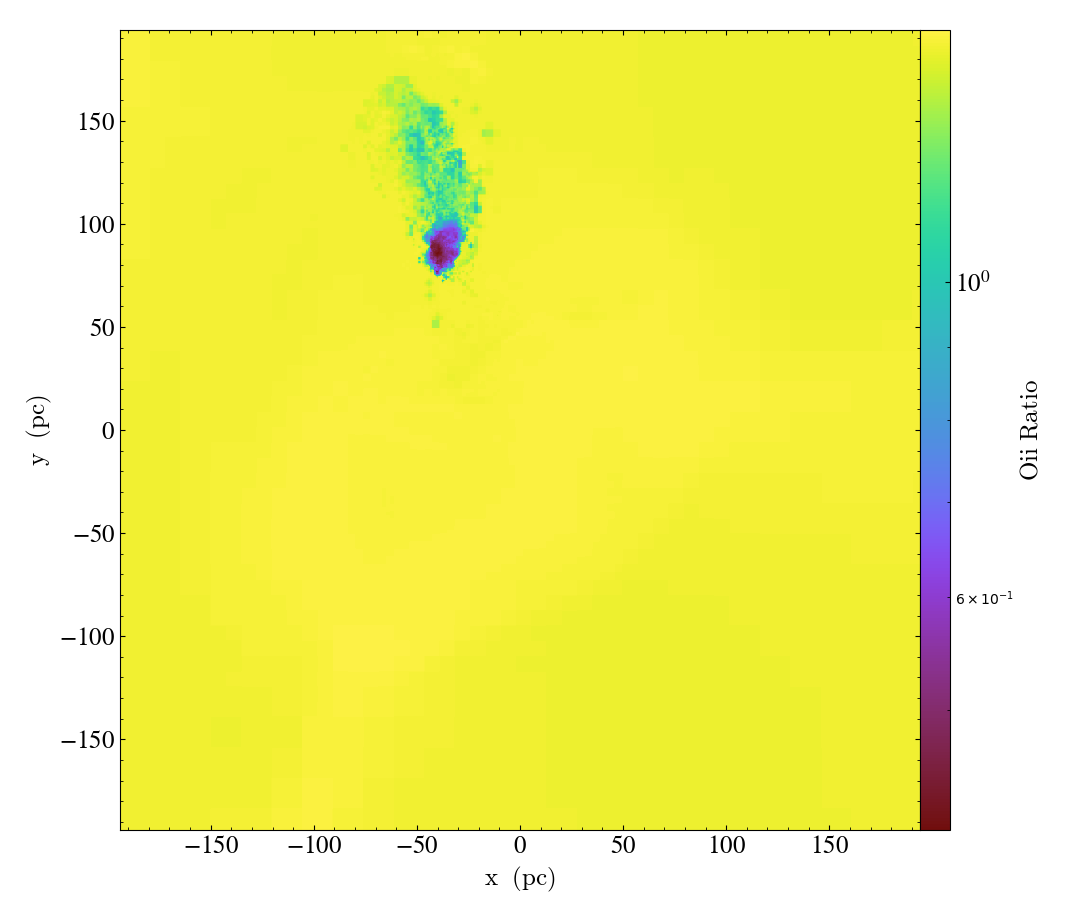

In [22]:
p = yt.ProjectionPlot(ds, "z", ("gas", "OII_ratio"), width=0.0001,
                      weight_field=("gas", "number_density"),
                      buff_size=(1000, 1000),
                      data_source=sp,
                      center=[0.49118094, 0.49275361, 0.49473726])

p.show()

/Users/bnowicki/Documents/GitHub/NebularLines/emission.py:95: RuntimeWarning: divide by zero encountered in log10
  T = np.log10(T_val)
yt : [INFO     ] 2024-10-28 18:16:23,447 xlim = 0.491136 0.491226
yt : [INFO     ] 2024-10-28 18:16:23,448 ylim = 0.492708 0.492799
yt : [INFO     ] 2024-10-28 18:16:23,449 xlim = 0.491136 0.491226
yt : [INFO     ] 2024-10-28 18:16:23,449 ylim = 0.492708 0.492799
yt : [INFO     ] 2024-10-28 18:16:23,450 Making a fixed resolution buffer of (('gas', 'OII_ratio')) 1000 by 1000



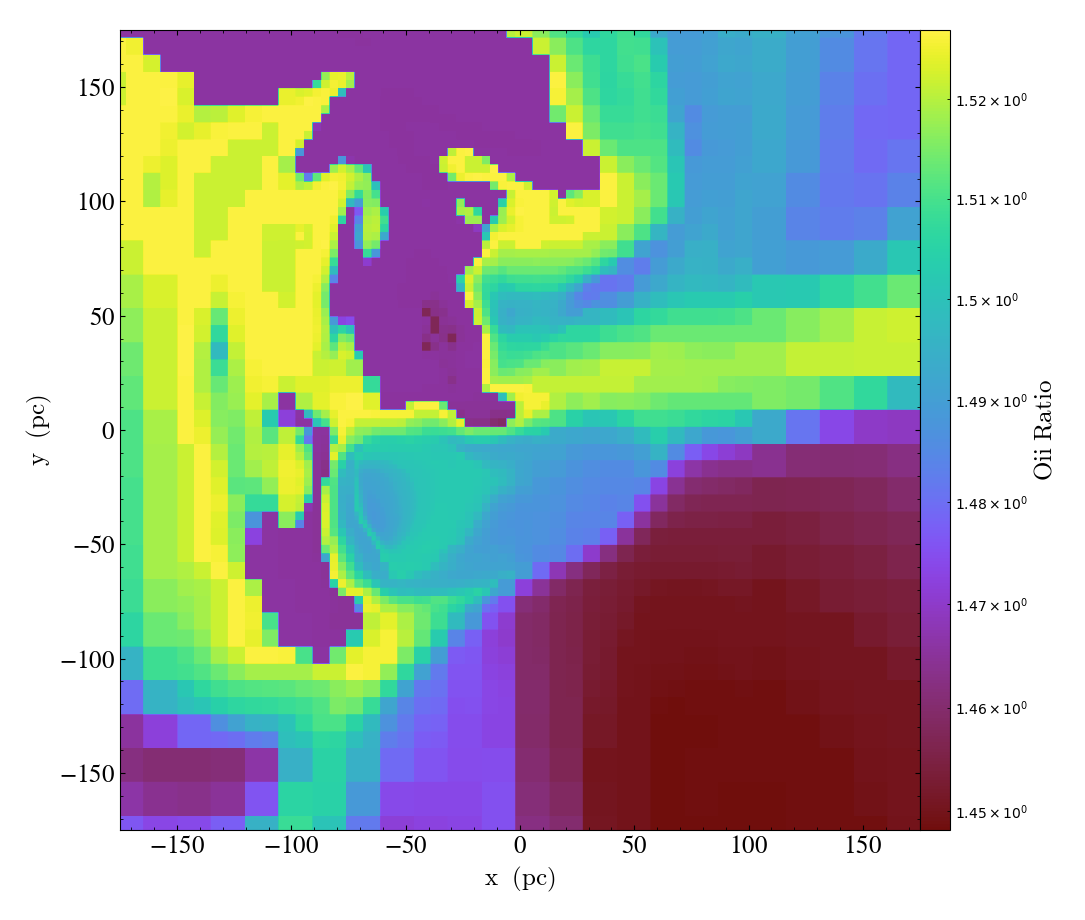

In [24]:
slc = yt.SlicePlot(
    ds,
    "z",
    ("gas", "OII_ratio"),
    center=[0.49118094, 0.49275361, 0.49473726],
    #center=("max", ("gas", "intensity_H1_6562.80A_[erg_cm^{-2}_s^{-1}]")),
    width=(350, "pc"),
    buff_size=(1000, 1000),
)

#slc.save()
slc.show()

yt : [INFO     ] 2024-10-16 23:04:08,245 Projection completed
yt : [INFO     ] 2024-10-16 23:04:08,248 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-16 23:04:08,248 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-16 23:04:08,250 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-16 23:04:08,251 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-16 23:04:08,252 Making a fixed resolution buffer of (('gas', 'H_p1_fraction')) 1000 by 1000



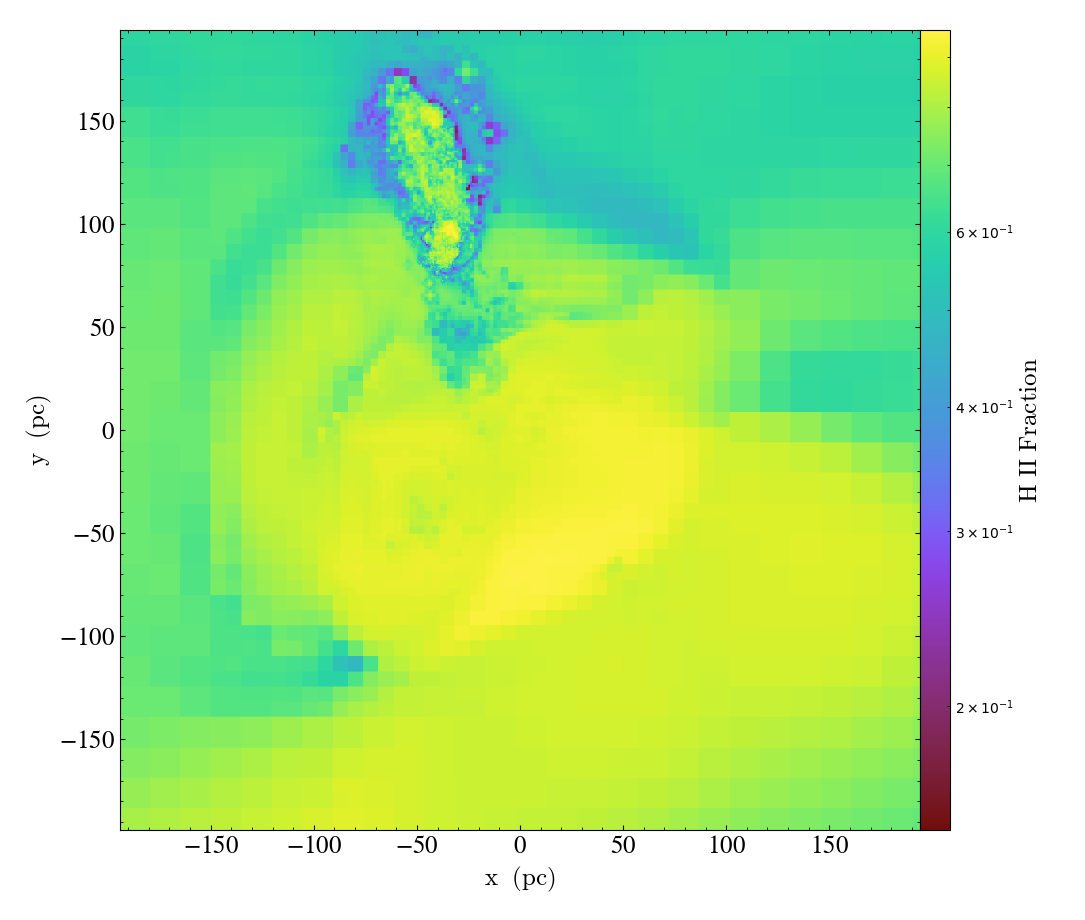

In [8]:
p = yt.ProjectionPlot(ds, "z", ("gas", "H_p1_fraction"), width=0.0001,
                      weight_field=("gas", "number_density"),
                      buff_size=(1000, 1000),
                      center=[0.49118094, 0.49275361, 0.49473726])

p.show()

### Alternatively, Project both OII emission lines then calculate ratio

yt : [INFO     ] 2024-10-28 18:12:35,716 Projection completed
yt : [INFO     ] 2024-10-28 18:12:35,717 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-28 18:12:35,717 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-28 18:12:35,718 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-28 18:12:35,718 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-28 18:12:35,719 Making a fixed resolution buffer of (('gas', 'intensity_O2_3728.80A')) 1000 by 1000
yt : [INFO     ] 2024-10-28 18:12:37,381 Projection completed
yt : [INFO     ] 2024-10-28 18:12:37,382 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-28 18:12:37,382 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-28 18:12:37,384 xlim = 0.491131 0.491231
yt : [INFO     ] 2024-10-28 18:12:37,384 ylim = 0.492704 0.492804
yt : [INFO     ] 2024-10-28 18:12:37,385 Making a fixed resolution buffer of (('gas', 'intensity_O2_3726.10A')) 1000 by 1000



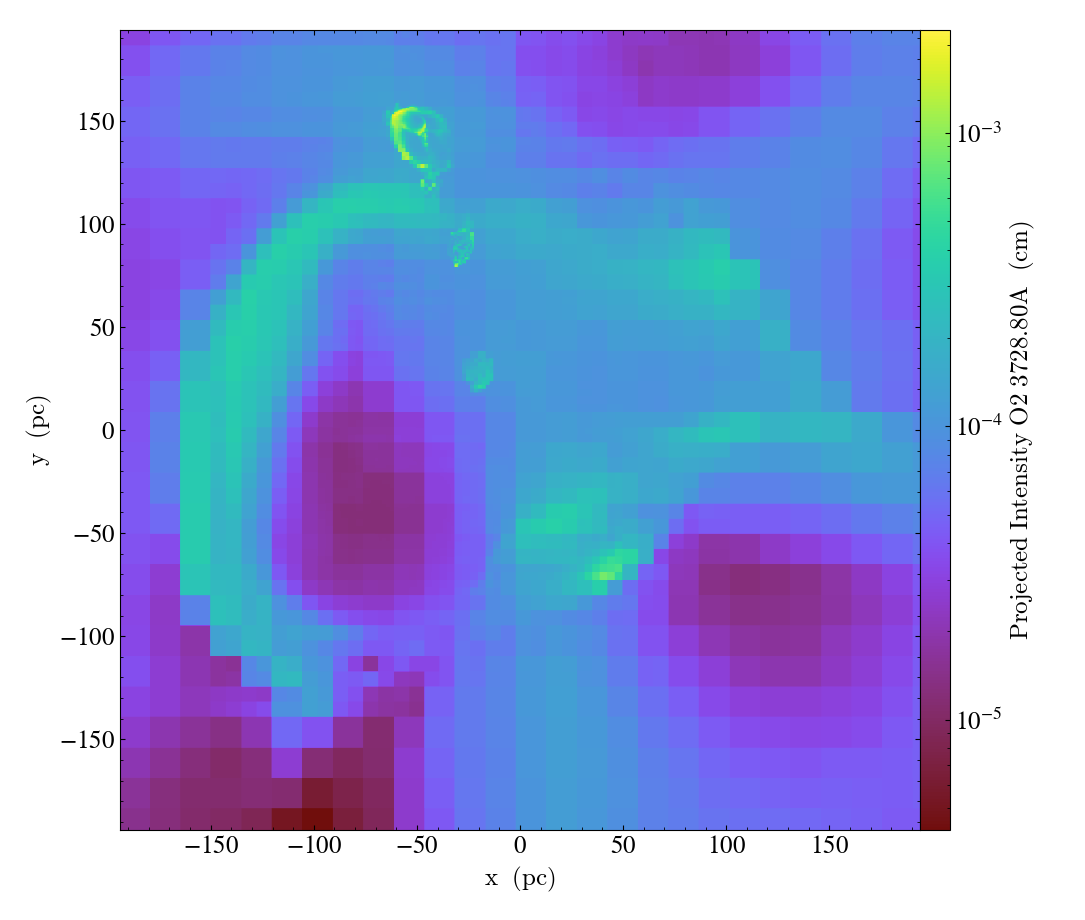


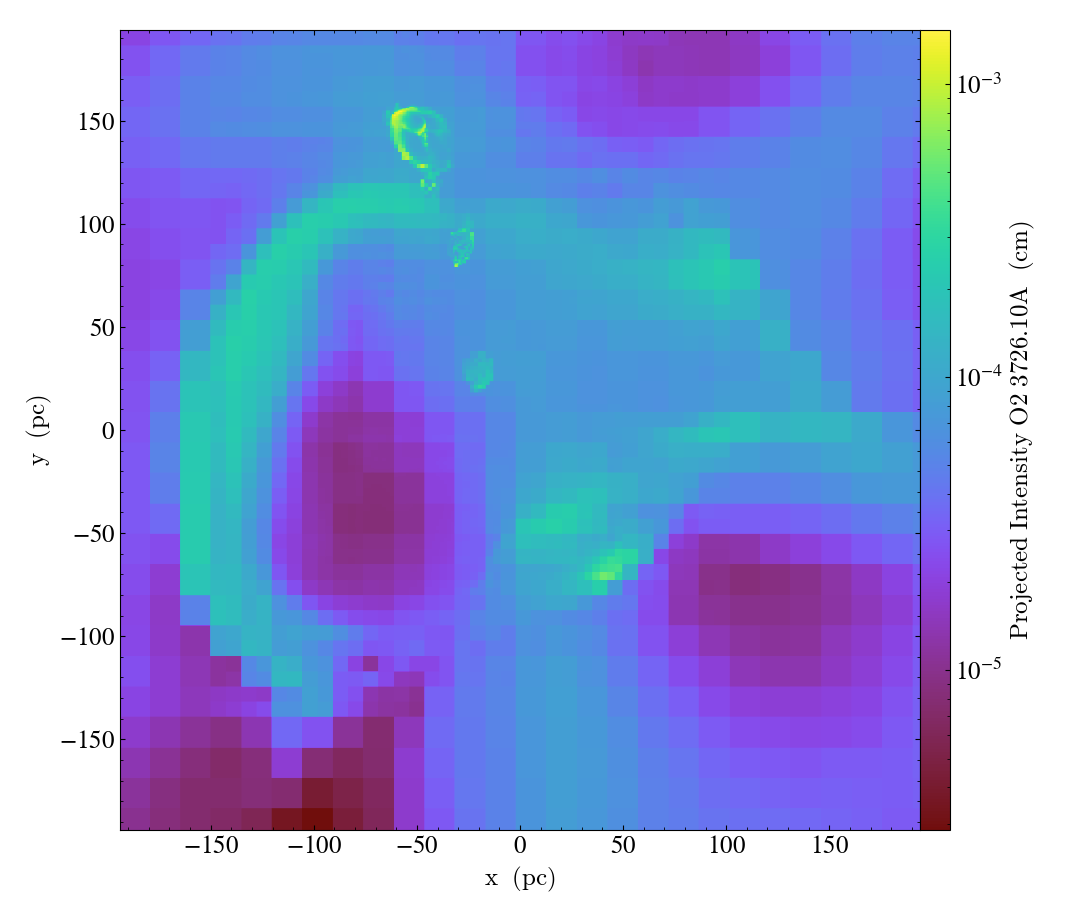

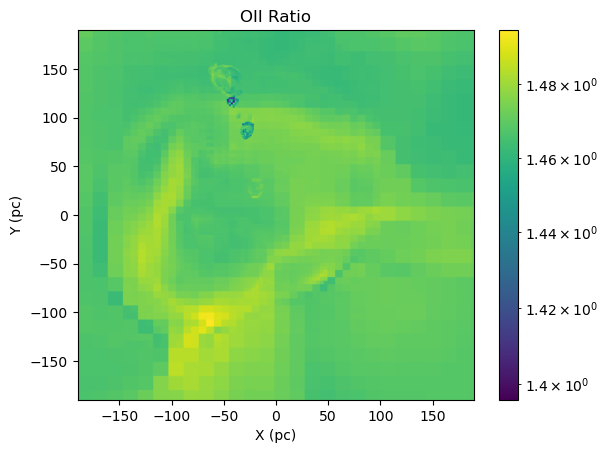

In [23]:
from matplotlib.colors import LogNorm

# Define the center for the projection
center = [0.49118094, 0.49275361, 0.49473726]

# Create Projection Plots
p1 = yt.ProjectionPlot(ds, "z", ("gas", "intensity_O2_3728.80A"), width=0.0001,
                      #weight_field=("gas", "number_density"), 
                      buff_size=(1000, 1000),
                      data_source=sp,
                      center=center)

p2 = yt.ProjectionPlot(ds, "z", ("gas", "intensity_O2_3726.10A"), width=0.0001,
                      #weight_field=("gas", "number_density"), 
                      buff_size=(1000, 1000),
                      data_source=sp,
                      center=center)

p1.show()
p2.show()

# Fixed-Resolution Buffer from the projection
p1_frb = p1.frb  
p2_frb = p2.frb
p1_img = np.array(p1_frb["gas", "intensity_O2_3728.80A"])
p2_img = np.array(p2_frb["gas", "intensity_O2_3726.10A"])
ratio = p1_img/p2_img

# Calculate limits for the plot
lbox = 380  # in pc
extent_dens = [-lbox/2, lbox/2, -lbox/2, lbox/2]
dens_norm = LogNorm(np.min(ratio), np.max(ratio))
# Ensure the aspect ratio of the image matches the scatter plot
plt.imshow(ratio, norm=dens_norm, extent=extent_dens, origin='lower', aspect='auto')
plt.xlabel("X (pc)")
plt.ylabel("Y (pc)")
plt.title("OII Ratio")
plt.xlim(-lbox/2, lbox/2)
plt.ylim(-lbox/2, lbox/2)
plt.colorbar()
plt.show()



In [25]:
print(np.min(ratio))

0.9640399169397919


## Slice Plots

yt : [INFO     ] 2024-10-16 23:24:51,678 max value is 1.39742e+05 at 0.4911709129810333 0.4927761256694794 0.4947503507137299
yt : [INFO     ] 2024-10-16 23:24:52,934 xlim = 0.491126 0.491216
yt : [INFO     ] 2024-10-16 23:24:52,935 ylim = 0.492731 0.492821
yt : [INFO     ] 2024-10-16 23:24:52,936 xlim = 0.491126 0.491216
yt : [INFO     ] 2024-10-16 23:24:52,936 ylim = 0.492731 0.492821
yt : [INFO     ] 2024-10-16 23:24:52,937 Making a fixed resolution buffer of (('gas', 'number_density')) 1000 by 1000



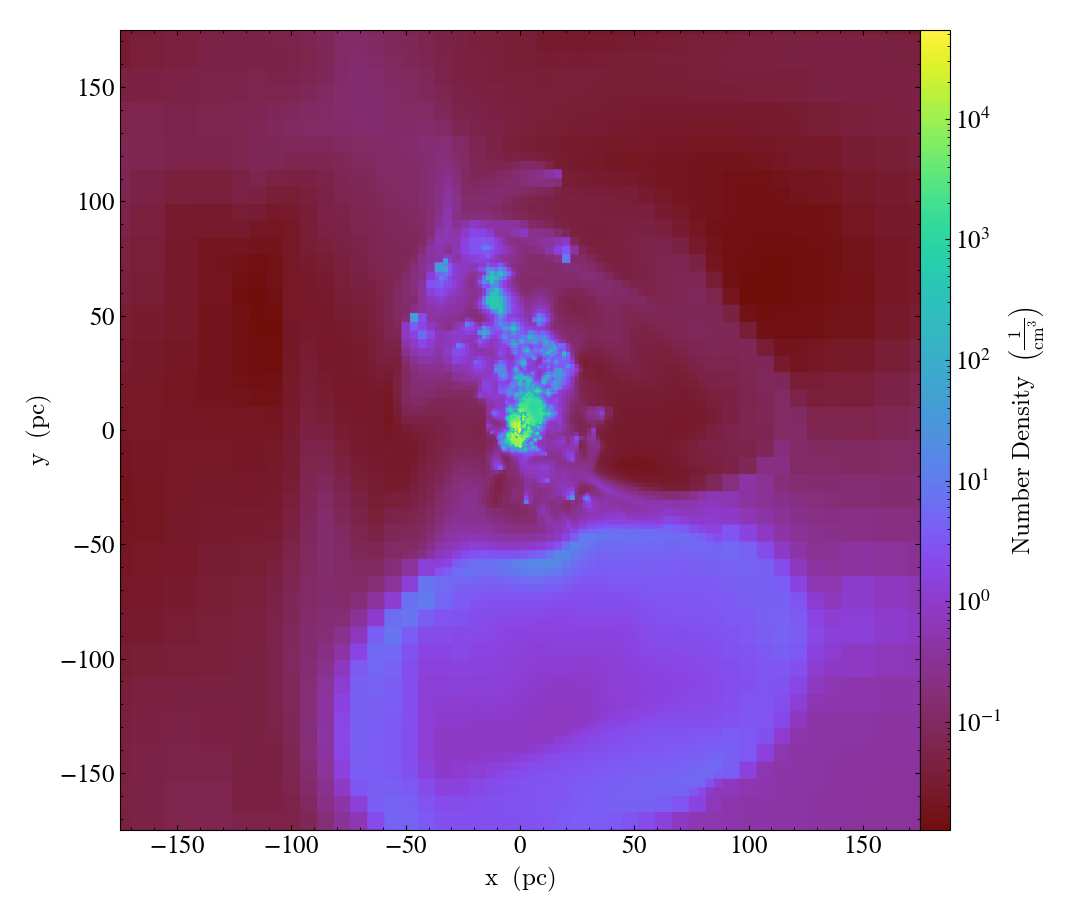

In [19]:
slc = yt.SlicePlot(
    ds,
    "z",
    ("gas", "number_density"),
    #center=[0.49118094, 0.49275361, 0.49473726],
    center=("max", ("gas", "number_density")),
    width=(350, "pc"),
    buff_size=(1000, 1000),
)

#slc.save()
slc.show()

In [63]:
print(ad.quantities.max_location(("gas", "intensity_H1_6562.80A_[erg_cm^{-2}_s^{-1}]")))
print(ad.quantities.max_location(("gas", "density")))

/var/folders/rh/cscbbcyd02lfdp3qqy7mdmjm0000gn/T/ipykernel_89127/1815844088.py:63: RuntimeWarning: divide by zero encountered in log10
  T = np.log10(data['gas', 'temperature'].value)


[unyt_quantity(8.67997483e-15, '(dimensionless)'), unyt_quantity(0.49117072, 'code_length'), unyt_quantity(0.49277569, 'code_length'), unyt_quantity(0.49474852, 'code_length')]
[unyt_quantity(2.75715809e-19, 'g/cm**3'), unyt_quantity(0.49117097, 'code_length'), unyt_quantity(0.49277607, 'code_length'), unyt_quantity(0.49475041, 'code_length')]


/var/folders/rh/cscbbcyd02lfdp3qqy7mdmjm0000gn/T/ipykernel_89127/3069468269.py:63: RuntimeWarning: divide by zero encountered in log10
  T = np.log10(data['gas', 'temperature'].value)
yt : [INFO     ] 2024-10-17 16:25:24,532 xlim = 0.491136 0.491226
yt : [INFO     ] 2024-10-17 16:25:24,533 ylim = 0.492708 0.492799
yt : [INFO     ] 2024-10-17 16:25:24,534 xlim = 0.491136 0.491226
yt : [INFO     ] 2024-10-17 16:25:24,535 ylim = 0.492708 0.492799
yt : [INFO     ] 2024-10-17 16:25:24,536 Making a fixed resolution buffer of (('gas', 'intensity_H1_6562.80A_[erg_cm^{-2}_s^{-1}]')) 1000 by 1000



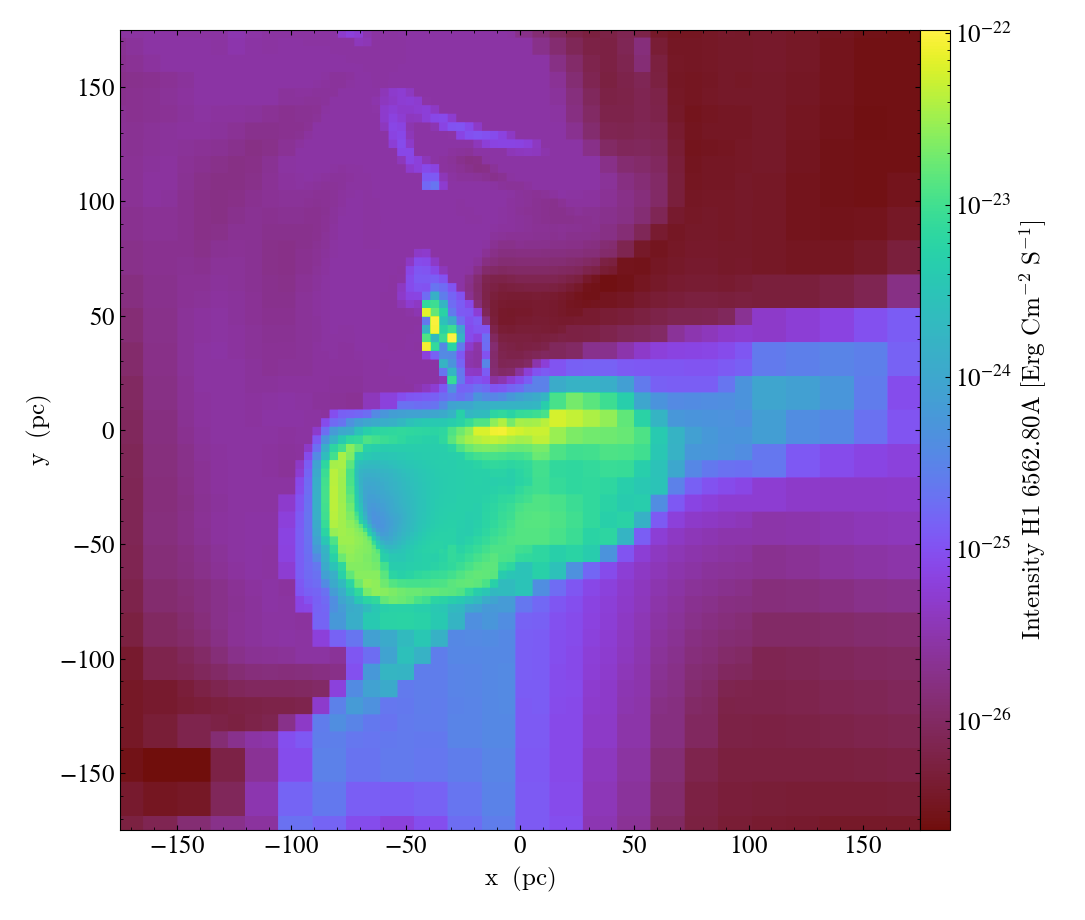

In [61]:
slc = yt.SlicePlot(
    ds,
    "z",
    ("gas", "intensity_H1_6562.80A_[erg_cm^{-2}_s^{-1}]"),
    center=[0.49118094, 0.49275361, 0.49473726],
    #center=("max", ("gas", "intensity_H1_6562.80A_[erg_cm^{-2}_s^{-1}]")),
    width=(350, "pc"),
    buff_size=(1000, 1000),
)

#slc.save()
slc.show()